# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', None)

In [2]:
url_t = 'https://video.udacity-data.com/topher/2018/November/5bf60fbf_twitter-archive-enhanced/twitter-archive-enhanced.csv'
response = rq.get(url_t)
content = response.content
with open(url_t.split('/')[-1], 'wb') as f:
    f.write(content)
df_twitter_archive = pd.read_csv(url_t.split('/')[-1])
    

In [3]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = rq.get(url)
content = response.content

# saving the file
with open(url.split('/')[-1], 'wb') as f:
    f.write(content)
df_prediction = pd.read_csv(url.split('/')[-1], sep = '\t')
df_prediction.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [5]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [6]:
df_prediction['tweet_id'] = df_prediction['tweet_id'].astype(str)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
import tweepy
import os
import json

client = tweepy.Client('AAAAAAAAAAAAAAAAAAAAADBffgEAAAAADtPMGLFWr4P5H49uCWjb3Gdxzok%3DygMZ6kW7q2Syu4JOPos3aD3WByqeCoHNZdh8dS5cAJzv7ylG4b')


In [8]:
# since we're only concerned with tweets used in the prediction,
#  we will query tweets using the ids available in that dataframe

# creating a tweet id list from the prediction dataframe
tweet_list = list(df_prediction.tweet_id.values)

# since the tweets rate limit is 900 requests per 15 minutes, and we have more than 2000 tweets, 
#  we need to query for the maxmimum number of tweets per request, which is 100 
#  So, the total requests we need to make to collect 2K tweets is = 2000/100 = 20 requests + 1 request which contains 75 tweets
#  Thus no need to set the rate limit since we're way below the limit of 900 requests per 15 minutes.

#making a list of lists , each list is a list of 100 tweet ids, and in case the list has less than 100, we slice the remainder.
tweet_ids = [tweet_list[i:i+100]  if len(tweet_list[i:]) >= 100 else tweet_list[i:] for i in range(0, len(tweet_list), 100)]
tweets_list = []

# check if tweet_json.txt exists, if it does, delete it [to avoid the file building up over and over when testing]
# if os.path.exists('tweet_json.txt'):
#    os.remove('tweet_json.txt')
    
for j, ids in enumerate(tweet_ids):
    # we include public metrics to access the tweet likes and retweets.

    tweets = client.get_tweets([int(id) for id in ids], tweet_fields='public_metrics')

    for i,tweet in enumerate(tweets.data):
        # print the error message
        

        # This step is only done to complete this part of the assignment: To save the query in a tweet_json.txt file.

        # check if tweet_json.txt file exists, if not, create it.
        # if not os.path.exists('tweet_json.txt'):
        #     with open('tweet_json.txt', 'w') as f:
        #         f.write(json.dumps(tweet.data))
        # else:
        #     with open('tweet_json.txt', 'a') as f:
        #         f.write('\n')
        #         f.write(json.dumps(tweet.data))
        
        # It is much more straightforward to get the desired features directly in the following format
        tweets_list.append([tweet.id, tweet.public_metrics['retweet_count'], tweet.public_metrics['like_count']])



In [9]:
# populate a dataframe with tweet_id, retweet_count, and like_count
df_tweet = pd.DataFrame(tweets_list, columns=['tweet_id', 'retweet_count','like_count'])       

In [10]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   tweet_id       2057 non-null   int64
 1   retweet_count  2057 non-null   int64
 2   like_count     2057 non-null   int64
dtypes: int64(3)
memory usage: 48.3 KB


In [11]:
# some tweet_ids were missed, investigating the discrepencies
# first, we map out the tweets that are missing from df_tweet but exist in the prediction dataframe
check = df_prediction.tweet_id.apply(lambda x: int(x))

missed = df_prediction[check.isin(df_tweet.tweet_id.values).values== False].tweet_id.values

# Trying to request the missed tweets from the twitter api
miss_tweets = client.get_tweets(list(missed), tweet_fields='public_metrics')

In [12]:
# pulling the value which contains the id, and title which contains error details
error_catch = [(x['value'], x['title']) for x in  miss_tweets.errors]

# looping over the missing tweets and printing the error details
for i,e in enumerate(error_catch):
    print(f'{i+1}. ID = {e[0]}  ERROR= {e[1]}')

1. ID = 680055455951884288  ERROR= Not Found Error
2. ID = 754011816964026368  ERROR= Not Found Error
3. ID = 759566828574212096  ERROR= Not Found Error
4. ID = 759923798737051648  ERROR= Not Found Error
5. ID = 771004394259247104  ERROR= Authorization Error
6. ID = 779123168116150273  ERROR= Not Found Error
7. ID = 802247111496568832  ERROR= Not Found Error
8. ID = 829374341691346946  ERROR= Not Found Error
9. ID = 837012587749474308  ERROR= Not Found Error
10. ID = 837366284874571778  ERROR= Not Found Error
11. ID = 842892208864923648  ERROR= Not Found Error
12. ID = 844704788403113984  ERROR= Not Found Error
13. ID = 851861385021730816  ERROR= Not Found Error
14. ID = 851953902622658560  ERROR= Not Found Error
15. ID = 861769973181624320  ERROR= Not Found Error
16. ID = 872261713294495745  ERROR= Not Found Error
17. ID = 873697596434513921  ERROR= Not Found Error
18. ID = 888202515573088257  ERROR= Not Found Error


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [13]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
df_twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

There are some entries with invalid names

In [15]:
df_tweet.duplicated().sum(), df_prediction.duplicated().sum(), df_twitter_archive.duplicated().sum()

(0, 0, 0)

In [16]:
df_twitter_archive.query('rating_numerator > 100')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
188   855862651834028034           8.558616e+17         1.943518e+08   
189   855860136149123072           8.558585e+17         1.361572e+07   
290   838150277551247360           8.381455e+17         2.195506e+07   
313   835246439529840640           8.352460e+17         2.625958e+07   
902   758467244762497024                    NaN                  NaN   
979   749981277374128128                    NaN                  NaN   
1120  731156023742988288                    NaN                  NaN   
1634  684225744407494656           6.842229e+17         4.196984e+09   
1635  684222868335505415                    NaN                  NaN   
1779  677716515794329600                    NaN                  NaN   
2074  670842764863651840                    NaN                  NaN   

                      timestamp  \
188   2017-04-22 19:15:32 +0000   
189   2017-04-22 19:05:32 +0000   
290   2017-03-04 22:12:52 +0000   
313   2017-02-24 21:54:03 +0000   
902   2016-07-28 01:00:57 +0000   
979   2016-07-04 15:00:45 +0000   
1120  2016-05-13 16:15:54 +0000   
1634  2016-01-05 04:11:44 +0000   
1635  2016-01-05 04:00:18 +0000   
1779  2015-12-18 05:06:23 +0000   
2074  2015-11-29 05:52:33 +0000   

                                                                                   source  \
188    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
189    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
290    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
313    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
902    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
979   <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>   
1120   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1634   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1635   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1779   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2074   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                              text  \
188                                                         @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research   
189          @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10   
290                                                                                                                             @markhoppus 182/10   
313                                             @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho   
902                                                                 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE   
979                                                                 This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh   
1120                     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv   
1634                Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3   
1635  Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55   
1779                                                                        IT'S PUPPERGEDDON. Total of 144/120 .

### Quality issues
1. `timestamp` in `df_twitter_archive` column are in object/string format. Needs to be changed to datetime format

2. Columns `name` till `puppo` in `df_twitter_archive` have `None` values but are in string format. Need to appropriately change to `None`.

3. `tweet_id` column in `df_twitter_archive` is int format, need to change to string format.

4. Some name entries in `df_twitter_archive.name` are invalid (`'a'`, `'just'`, etc). need to replace invalid entries with `None`.

5. Rating numerator in `df_twitter_archive` has invalid inputs (exagerrated outliers), and denominator as `00` value which is erroneous.

6. Denominator of tweets in `df_twitter_archive` are inconsistent (according to WeRateDogs wikipedia page, it should always be out of 10). Need to exclude tweets with invalid rates

7. tweets that are missing `expanded_urls` should be removed

8. There are entries missing from `df_tweet` when compared to the `df_twitter_archive` dataframe, only ids that exist in both shall be maintained.

### Tidiness issues
1. Columns `doggo` till `puppo` are actually one variable `stage`, need to be combined into one column stage

2. Rating numerator and denominator are actually one variable `rating`, need to be combined into one column rating

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [17]:
# Make copies of original pieces of data
df_archive_clean = df_twitter_archive.copy()
df_prediction_clean = df_prediction.copy()
df_tweet_clean = df_tweet.copy()


### Issue #1:

#### Define: 

`timestamp` in `df_twitter_archive` should be in datetime format 

#### Code

In [18]:
# convert the type of timestamp from str to datetime
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

#### Test

In [19]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #2:

#### Define:

Columns `name` till `puppo` in `df_twitter_archive` have `None` values but are in string format. Need to appropriately change to `None`.

#### Code

In [20]:
columns = ['name', 'doggo', 'floofer', 'pupper', 'puppo']

for column in columns:
    df_archive_clean[column] = df_archive_clean[column].apply(lambda x: None if x == 'None' else x)

#### Test

In [21]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #3:

#### Define:

`tweet_id` column in `df_twitter_archive` is int format, need to change to string format.

#### Code

In [22]:
# convert tweet_id to string
df_archive_clean.tweet_id =  df_archive_clean.tweet_id.astype(str)

# also, the df_tweet tweet_id is in int, convert it to string
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

#### Test

In [23]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

### Issue #4:

#### Define:

Some name entries in `df_twitter_archive` are invalid (`'a'`, `'just'`, etc). need to replace invalid entries with `None`.

The method by which this information was extracted seems to be taking whatever comes after 'This is' in the text. To better improve this it should check for presence of 'name' and take whatever is in `Title` form after 'name' or 'This is'.

#### Code

In [24]:
# first we check the format, if the name isn't capitalized, it's most likely not a name
df_archive_clean.name = df_archive_clean.name.apply(lambda x: x if x != None and x[0] == x[0].upper() else None)



#### Test

In [25]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [26]:
df_archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', None, 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Emmy',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra', 'Monkey',
       'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn', 'Boomer',
       'Cody', 'Rumble', 'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Cooper',
       'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Quinn', 'Belle', 'Zooey'

### Issue #5:

#### Define:

Rating numerator in `df_twitter_archive` has invalid inputs along with decimals not extracted correctly, need to sue text to re-extract

#### Code

In [27]:
# The exagerrated rating is due to the fact that some photos contain multiple dogs, or . 
# Since the ratings are sometimes expressed as  total number of dogs 
#  (two dogs 6/10 can be expressed as 12/20). for that reason ratings that are more than 120
#  are considered exagerrated (for sake of memes, i.e. 420/10).


def extract_rating(x):

    x = x.replace('\n',' ')
    x = x.replace('&amp;',' ')
    text = x.split(' ')

    text = [t for t in text if t.__contains__('/')]

    for i in text:
        r = i.split('/')
        
        # cleaning denominator r[1], denominator is always a whole number
        for idx,chr in enumerate(r[1]):
            # the first character should be a number else break
            if chr.isdigit():
                while idx+1 < len(r[1]):
                    # step to the next character
                    idx +=1
                    # if the next character was a number, continue
                    if r[1][idx].isdigit():
                        continue
                    # if the next character was not a number, break and return the slice up until the character
                    else:
                        r[1] = r[1][:idx]
            else:
                break
        # checking and cleaning the numerator r[0]
        if len(r) == 2 and r[1].isdigit() and int(r[1])%10 == 0:
            for idx,j in enumerate(r[0]):
                rest_of_string = r[0][idx:]

                # check if the character is not a digit
                if not j.isdigit():
                    # go to the next iteration if it is not a digit
                    continue

                # check if the remaining characters are digits, meaning it's not a decimal
                if rest_of_string.isdigit():
                    # return the number
                    return rest_of_string + '/' + r[1] 

                # check if the remaining characters contain one 'decimal point'
                if rest_of_string.__contains__('.') and rest_of_string.count('.') == 1:
                    # split the string by . and check if both sides are digits
                    if all([ k.isdigit() for k in rest_of_string.split('.')]):
                        return rest_of_string + '/' + r[1]
    return None


df_archive_clean['rating'] = df_archive_clean['text'].apply(extract_rating)

# from rating, copy the numerator to rating_numerator and denominator to rating_denominator
df_archive_clean['rating_numerator'] = df_archive_clean['rating'].apply(lambda x: float(x.split('/')[0]) if x != None else None)
df_archive_clean['rating_denominator'] = df_archive_clean['rating'].apply(lambda x: float(x.split('/')[1]) if x != None else None)






#### Test

In [28]:
df_archive_clean.rating.unique()

array(['13/10', '12/10', '14/10', '13.5/10', '17/10', '11/10', '10/10',
       '420/10', '666/10', '6/10', '15/10', '182/10', '960/00', '0/10',
       '9.75/10', None, '007/10', '84/70', '7/10', '9/10', '8/10', '1/10',
       '5/10', '11.27/10', '3/10', '4/10', '165/150', '1776/10',
       '204/170', '4/20', '50/50', '99/90', '80/80', '45/50', '60/50',
       '44/40', '143/130', '121/110', '9.5/10', '11.26/10', '2/10',
       '144/120', '88/80'], dtype=object)

In [29]:
df_archive_clean.query('rating.isna()')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
342   832088576586297345           8.320875e+17         3.058208e+07   
516   810984652412424192                    NaN                  NaN   
1663  682808988178739200           6.827884e+17         4.196984e+09   

                     timestamp  \
342  2017-02-16 04:45:50+00:00   
516  2016-12-19 23:06:23+00:00   
1663 2016-01-01 06:22:03+00:00   

                                                                                  source  \
342   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
516   <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1663  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                           text  \
342                                                                                                                                    @docmisterio account started on 11/15/15   
516   Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   
1663                                I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible   

      retweeted_status_id  retweeted_status_user_id  \
342                   NaN                       NaN   
516                   NaN                       NaN   
1663                  NaN                       NaN   

     retweeted_status_timestamp  \
342                         NaN   
516                         NaN   
1663                        NaN   

                                                                                            expanded_urls  \
342                                                                                                   NaN   
516   https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1   
1663                                                                                                  NaN   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  \
342                NaN                 NaN  None  None    None   None  None   
516                NaN                 NaN   Sam  None    None   None  None   
1663               NaN                 NaN  None  None    None   None  None   

     rating  
342    None  
516    None  
1663   None

In [30]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2353 non-null   float64         

### Issue #6:

#### Define:

Denominator of tweets in `df_twitter_archive` are inconsistent (according to WeRateDogs wikipedia page, it should always be out of 10). Need to exclude tweets with invalid rates

#### Code

In [31]:
# if the denominator is 0 or not divisible by 10, then the rating is invalid
df_archive_clean = df_archive_clean.query('rating_denominator%10 == 0 and rating_denominator != 0')

#### Test

In [32]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2352 non-null   object             
 1   in_reply_to_status_id       75 non-null     float64            
 2   in_reply_to_user_id         75 non-null     float64            
 3   timestamp                   2352 non-null   datetime64[ns, UTC]
 4   source                      2352 non-null   object             
 5   text                        2352 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2296 non-null   object             
 10  rating_numerator            2352 non-null   float64         

### Issue #7:

#### Define:

tweets that are missing `expanded_urls` should be removed since they don't have images in them.

#### Code

In [33]:
# convert the tweet_id to string
df_archive_clean = df_archive_clean.query('not expanded_urls.isna()')

#### Test

In [34]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2296 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2296 non-null   datetime64[ns, UTC]
 4   source                      2296 non-null   object             
 5   text                        2296 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    object             
 9   expanded_urls               2296 non-null   object             
 10  rating_numerator            2296 non-null   float64         

### Issue #8:

#### Define:

There are about  entries missing from `df_tweet` when compared to the `df_twitter_archive` dataframe, only ids that exist in both shall be maintained.

#### Code

In [35]:
# check for tweet_id in df_archive_clean that exist in df_tweet.tweet_id

# query the tweet_ids that exist in both tweet_ids and df_archive_clean
df_archive_clean = df_archive_clean.query('tweet_id in @df_tweet_clean.tweet_id')

#### Test

In [36]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2056 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2056 non-null   datetime64[ns, UTC]
 4   source                      2056 non-null   object             
 5   text                        2056 non-null   object             
 6   retweeted_status_id         71 non-null     float64            
 7   retweeted_status_user_id    71 non-null     float64            
 8   retweeted_status_timestamp  71 non-null     object             
 9   expanded_urls               2056 non-null   object             
 10  rating_numerator            2056 non-null   float64         

### Issue #9:


#### Define:

rows that have `retweet_id` should be removed since they are not original tweets.

rows that don't have a valid rating should be removed.


#### Code:

In [37]:
# rows the are not retweets will show as NaN in the retweeted status id column
df_archive_clean = df_archive_clean.query('retweeted_status_id.isna()')
# rows with nan for rating should be removed
df_archive_clean = df_archive_clean.query('not rating.isna()')

#### Test:


In [38]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1985 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1985 non-null   datetime64[ns, UTC]
 4   source                      1985 non-null   object             
 5   text                        1985 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1985 non-null   object             
 10  rating_numerator            1985 non-null   float64         

### Issue #1:

#### Define:

Columns `doggo` till `puppo` are actually one variable `stage`, need to be combined into one column stage

#### Code

In [39]:
# create a new column 'stage' which combines the values from 
# columns doggo, puppo, floofer, pupper, and if all the values 
# are None just assign it None
stages = ['pupper','puppo','doggo','floofer']


df_archive_clean['stage'] = df_archive_clean['doggo'].apply(lambda x: x if x != None else '') + df_archive_clean['floofer'].apply(lambda x: x if x != None else '') + df_archive_clean['pupper'].apply(lambda x: x if x != None else '') + df_archive_clean['puppo'].apply(lambda x: x if x != None else '') 

# if the value is empty assign it None
df_archive_clean['stage'] = df_archive_clean['stage'].apply(lambda x: x if x != '' else None)

#### Test

In [40]:
df_archive_clean.stage.unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [41]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1985 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1985 non-null   datetime64[ns, UTC]
 4   source                      1985 non-null   object             
 5   text                        1985 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1985 non-null   object             
 10  rating_numerator            1985 non-null   float64         

### Issue #2:

#### Define:

Rating numerator and denominator are actually one variable `rating`, need to be combined into one column `rating`, and consider the floating number to be the scale of each photo regardless of number of dogs in the photo.


#### Code

In [42]:
df_archive_clean = df_archive_clean[['tweet_id','timestamp','text','rating_numerator','rating_denominator','stage']]

# making a 'rating' column which is a float
df_archive_clean['rating'] = df_archive_clean['rating_numerator']/df_archive_clean['rating_denominator']

# dropping the columns that are not needed anymore
df_archive_clean = df_archive_clean.drop(['rating_numerator','rating_denominator'], axis=1)


#### Test

In [43]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 2355
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   1985 non-null   object             
 1   timestamp  1985 non-null   datetime64[ns, UTC]
 2   text       1985 non-null   object             
 3   stage      305 non-null    object             
 4   rating     1985 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 93.0+ KB


In [44]:
df_archive_clean.head(3)

tweet_id                 timestamp  \
0  892420643555336193 2017-08-01 16:23:56+00:00   
1  892177421306343426 2017-08-01 00:17:27+00:00   
2  891815181378084864 2017-07-31 00:18:03+00:00   

                                                                                                                                                                 text  \
0                                                       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   
2                   This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB   

  stage  rating  
0  None     1.3  
1  None     1.3  
2  None     1.2

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [45]:
df_master_archive = df_archive_clean.copy()
df_master_archive['like_count'] = df_tweet_clean.like_count
df_master_archive['retweet_count'] = df_tweet_clean.retweet_count

# add the columns from df_prediction to the df_master_archive
df_master_archive = df_master_archive.merge(df_prediction, on='tweet_id')

#save the master archive to a csv file with name 'twitter_archive_master.csv'
df_master_archive.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, the data analysis will be performed to obtain some insights on the WeRateDogs data. The data was cleaned and tidied previously, going forward, some questions will be asked to formulate the insights on the data. This analysis will not consider the number of dogs present in a picture.

##### Questions:
1. Does the rating reflect higher like count?
2. Does the dog stage affect the rating (younger dogs are rated higher than older dogs)?
3. Which dog stage is more retweeted?

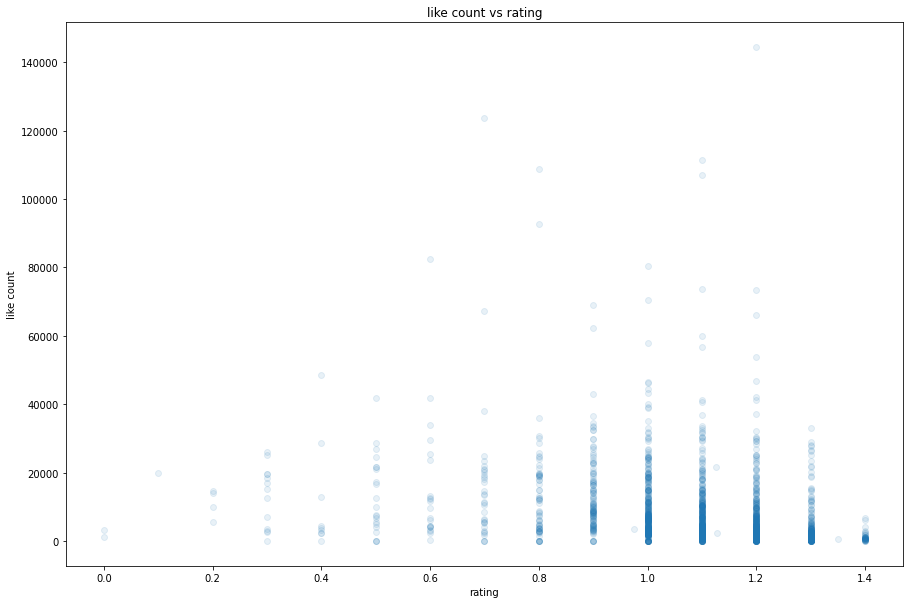

In [46]:
# load the twitter_archive_master.csv file to df_master
df_master = pd.read_csv('twitter_archive_master.csv')

df_master.head()

# plot the scatter plot between like count and rating
plt.figure(figsize=(15,10))
plt.scatter(df_master.query('rating <10').rating, df_master.query('rating < 10').like_count, alpha=0.1)
plt.ylabel('like count')
plt.xlabel('rating')
plt.title('like count vs rating')

plt.show()

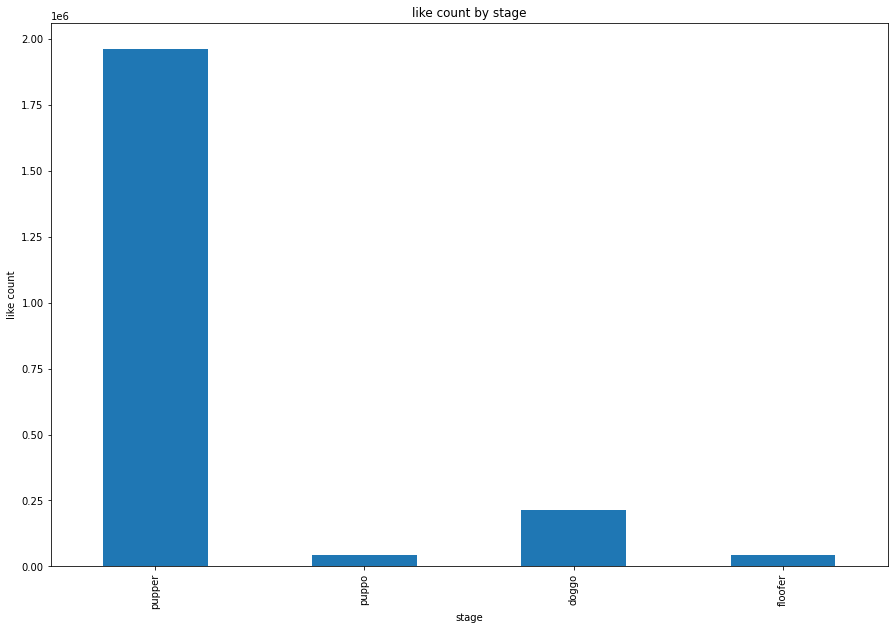

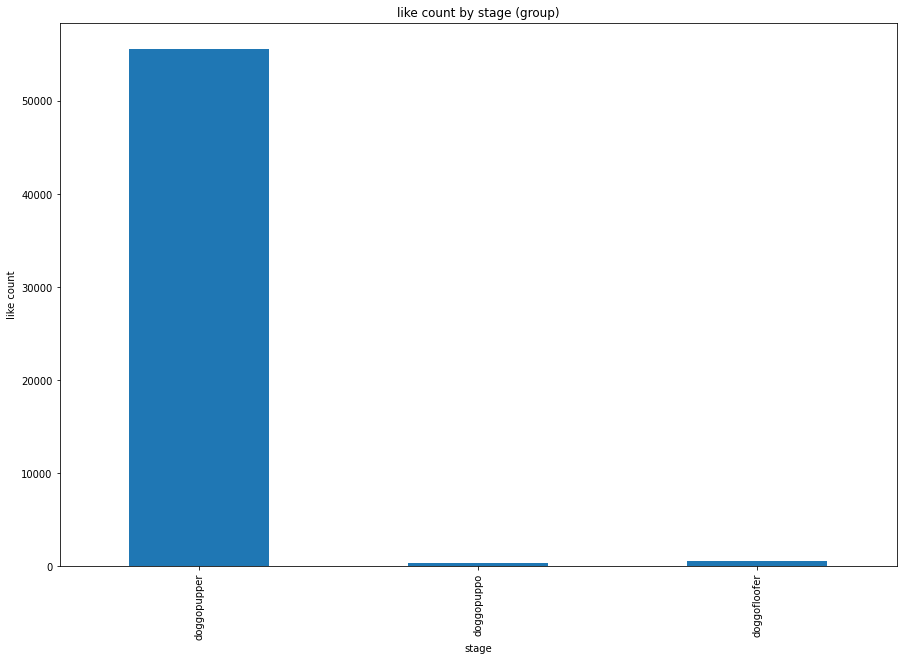

In [47]:
stage_sort = stages
stage_multi_sort = ['doggopupper','doggopuppo','doggofloofer']

# sort the dataframe by stage_sort and plot bar chart of like_count
df_master.query('stage in @stage_sort').groupby('stage').like_count.sum().reindex(stage_sort).plot(kind='bar', figsize=(15,10))
plt.title('like count by stage')
plt.ylabel('like count')
plt.show()
df_master.query('stage in @stage_multi_sort').groupby('stage').like_count.sum().reindex(stage_multi_sort).plot(kind='bar', figsize=(15,10))
plt.title('like count by stage (group)')
plt.ylabel('like count')
plt.show()

### Insights:
1. Dogs between rating 9 and 11 receive more likes than other rating. but this is not a significant finding.


2. the youngest stage dogs are liked most (pupper)

3. the youngest stage dogs are retweeted most (pupper)

### Visualization

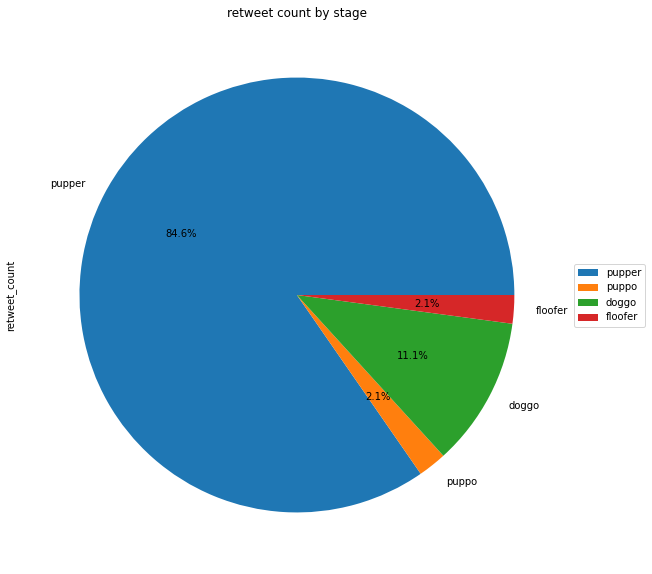

In [48]:
df_master.query('stage in @stage_sort').groupby('stage').retweet_count.sum().reindex(stage_sort).plot(kind='pie', figsize=(20,10), autopct='%1.1f%%')
plt.title('retweet count by stage')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# preveiw chart percentage
plt.show()

